In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

from sklearn.model_selection import train_test_split

## Import dataset

In [23]:
df = pd.read_csv("data/daily_min_temp.csv", parse_dates=["Date"])
df['quarter'] = df.Date.dt.quarter
df = pd.get_dummies(df, columns=['quarter'])
df.set_index("Date", inplace=True)
df.head()

,Temp,quarter_1,quarter_2,quarter_3,quarter_4
Date,,,,,
1981-01-01,20.7,1,0,0,0
1981-01-02,17.9,1,0,0,0
1981-01-03,18.8,1,0,0,0
1981-01-04,14.6,1,0,0,0
1981-01-05,15.8,1,0,0,0


## Scaling 

In [24]:
# df['Temp'] = df['Temp'].transform(lambda x: (x - x.mean()) / x.std())

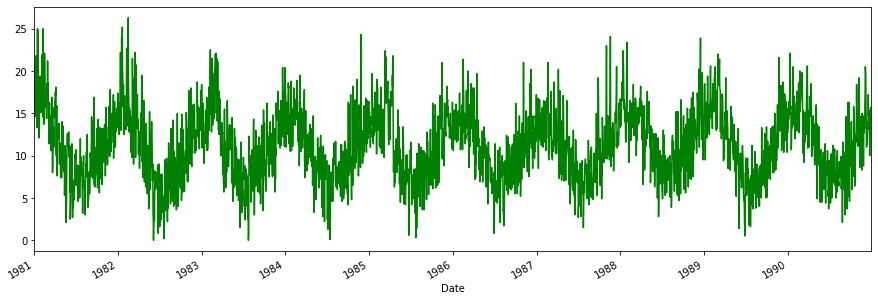

In [25]:
df.Temp.plot(figsize=(15,5), color='g');

## Dataset Splitting

In [26]:
## Pada data time series data tidak boleh dishuffle(diacak) 
ts_train, ts_test = train_test_split(df, test_size=0.2, shuffle=False)
ts_train.shape, ts_test.shape

((2920, 5), (730, 5))

## Dataset dan Dataloader

In [27]:
from jcopdl.utils.dataloader import TimeSeriesDataset
from torch.utils.data import DataLoader

In [111]:
seq_len = 14
bs = 32

train_set = TimeSeriesDataset(ts_train, 'Temp', seq_len)
trainloader = DataLoader(train_set, batch_size=bs)

test_set = TimeSeriesDataset(ts_test, 'Temp', seq_len)
testloader = DataLoader(test_set, batch_size=bs)

(N, S, F): (208, 14, 5)
Note: last 7 data excluded

(N, S, F): (52, 14, 5)
Note: last 1 data excluded



- N = Jumlah data
- S = Squence
- F = Feature

## Arsitektur dan config

In [112]:
class GRU(nn.Module):
    def __init__(self, input_size,output_size, hidden_size, num_layers, dropout):
        super().__init__()
        
        self.rnn = nn.GRU(input_size, hidden_size, num_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x, hidden):
        x, hidden = self.rnn(x, hidden)
        x = self.fc(x)
        return x, hidden

In [113]:
config = set_config({
    "input_size": train_set.n_feature,
    "seq_len": train_set.n_seq,
    "output_size":1,
    "hidden_size":256,
    "num_layers":2,
    "dropout":0
})

## Training Preparation

In [114]:
model = GRU(config.input_size, config.output_size, config.hidden_size, config.num_layers, config.dropout).to(device)
criterion = nn.MSELoss(reduction='mean')
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, outdir="model/multivar")

## Training

In [115]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output, hidden = model(feature, None)
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        cost += loss.item() * feature.shape[0]
    cost = cost / len(dataset)
    return cost



Epoch     1
Train_cost  = 92.9396 | Test_cost  = 38.7543 | 




Epoch     2
Train_cost  = 27.0847 | Test_cost  = 22.0273 | 




Epoch     3
Train_cost  = 19.2434 | Test_cost  = 18.7643 | 




Epoch     4
Train_cost  = 18.0911 | Test_cost  = 18.0733 | 




Epoch     5
Train_cost  = 17.6888 | Test_cost  = 17.5642 | 




Epoch     6
Train_cost  = 17.0619 | Test_cost  = 17.2939 | 




Epoch     7
Train_cost  = 16.6780 | Test_cost  = 17.3176 | 
==> EarlyStop patience =  1 | Best test_cost: 17.2939




Epoch     8
Train_cost  = 16.5622 | Test_cost  = 17.2860 | 




Epoch     9
Train_cost  = 16.4673 | Test_cost  = 17.1054 | 




Epoch    10
Train_cost  = 16.3560 | Test_cost  = 16.9248 | 




Epoch    11
Train_cost  = 16.2737 | Test_cost  = 16.8221 | 




Epoch    12
Train_cost  = 16.2116 | Test_cost  = 16.7759 | 




Epoch    13
Train_cost  = 16.1574 | Test_cost  = 16.7428 | 




Epoch    14
Train_cost  = 16.1056 | Test_cost  = 16.7028 | 




Epoch    15
Train_cost  = 16.0486 | Test_cost  = 16.6224 | 




Epoch    16
Train_cost  = 15.9556 | Test_cost  = 16.4667 | 




Epoch    17
Train_cost  = 15.8393 | Test_cost  = 16.3314 | 




Epoch    18
Train_cost  = 15.6949 | Test_cost  = 16.1622 | 




Epoch    19
Train_cost  = 15.5142 | Test_cost  = 15.9192 | 




Epoch    20
Train_cost  = 15.3096 | Test_cost  = 15.6581 | 


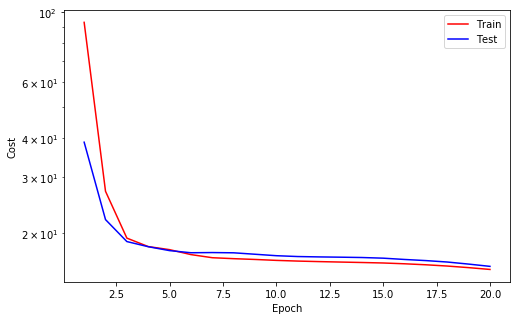



Epoch    21
Train_cost  = 15.0610 | Test_cost  = 15.3368 | 




Epoch    22
Train_cost  = 14.7819 | Test_cost  = 15.0332 | 




Epoch    23
Train_cost  = 14.5064 | Test_cost  = 14.7150 | 




Epoch    24
Train_cost  = 14.2188 | Test_cost  = 14.3872 | 




Epoch    25
Train_cost  = 13.9165 | Test_cost  = 14.0410 | 




Epoch    26
Train_cost  = 13.6175 | Test_cost  = 13.6809 | 




Epoch    27
Train_cost  = 13.2831 | Test_cost  = 13.2266 | 




Epoch    28
Train_cost  = 12.7871 | Test_cost  = 12.5984 | 




Epoch    29
Train_cost  = 12.2500 | Test_cost  = 11.9901 | 




Epoch    30
Train_cost  = 11.7523 | Test_cost  = 11.3725 | 




Epoch    31
Train_cost  = 11.2643 | Test_cost  = 10.8338 | 




Epoch    32
Train_cost  = 10.7848 | Test_cost  = 10.2314 | 




Epoch    33
Train_cost  = 10.2184 | Test_cost  = 9.5364 | 




Epoch    34
Train_cost  = 9.6265 | Test_cost  = 8.8479 | 




Epoch    35
Train_cost  = 9.0562 | Test_cost  = 8.2095 | 




Epoch    36
Train_cost  = 8.5261 | Test_cost  = 7.5511 | 




Epoch    37
Train_cost  = 7.9937 | Test_cost  = 6.9151 | 




Epoch    38
Train_cost  = 7.5202 | Test_cost  = 6.4623 | 




Epoch    39
Train_cost  = 7.1850 | Test_cost  = 6.1667 | 




Epoch    40
Train_cost  = 6.9263 | Test_cost  = 5.9535 | 


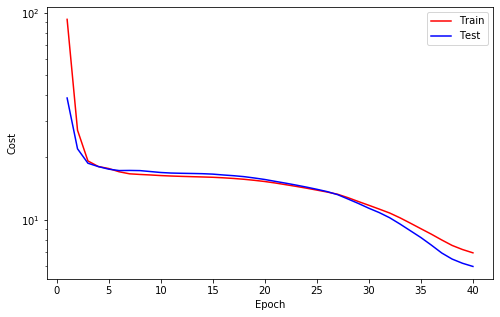



Epoch    41
Train_cost  = 6.7258 | Test_cost  = 5.8263 | 




Epoch    42
Train_cost  = 6.5801 | Test_cost  = 5.7316 | 




Epoch    43
Train_cost  = 6.4644 | Test_cost  = 5.6399 | 




Epoch    44
Train_cost  = 6.3764 | Test_cost  = 5.5148 | 




Epoch    45
Train_cost  = 6.2943 | Test_cost  = 5.4068 | 




Epoch    46
Train_cost  = 6.2388 | Test_cost  = 5.3252 | 




Epoch    47
Train_cost  = 6.2011 | Test_cost  = 5.2799 | 




Epoch    48
Train_cost  = 6.1712 | Test_cost  = 5.2468 | 




Epoch    49
Train_cost  = 6.1424 | Test_cost  = 5.2159 | 




Epoch    50
Train_cost  = 6.1120 | Test_cost  = 5.1860 | 




Epoch    51
Train_cost  = 6.0838 | Test_cost  = 5.1469 | 




Epoch    52
Train_cost  = 6.0558 | Test_cost  = 5.1131 | 




Epoch    53
Train_cost  = 6.0342 | Test_cost  = 5.0817 | 




Epoch    54
Train_cost  = 6.0152 | Test_cost  = 5.0582 | 




Epoch    55
Train_cost  = 5.9997 | Test_cost  = 5.0384 | 




Epoch    56
Train_cost  = 5.9847 | Test_cost  = 5.0232 | 




Epoch    57
Train_cost  = 5.9704 | Test_cost  = 5.0089 | 




Epoch    58
Train_cost  = 5.9560 | Test_cost  = 4.9964 | 




Epoch    59
Train_cost  = 5.9425 | Test_cost  = 4.9845 | 




Epoch    60
Train_cost  = 5.9297 | Test_cost  = 4.9744 | 


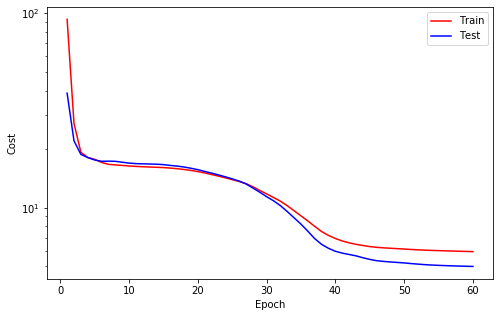



Epoch    61
Train_cost  = 5.9180 | Test_cost  = 4.9660 | 




Epoch    62
Train_cost  = 5.9073 | Test_cost  = 4.9607 | 




Epoch    63
Train_cost  = 5.9007 | Test_cost  = 4.9504 | 




Epoch    64
Train_cost  = 5.8915 | Test_cost  = 4.9782 | 
==> EarlyStop patience =  1 | Best test_cost: 4.9504




Epoch    65
Train_cost  = 5.8918 | Test_cost  = 4.9390 | 




Epoch    66
Train_cost  = 5.8706 | Test_cost  = 4.9469 | 
==> EarlyStop patience =  1 | Best test_cost: 4.9390




Epoch    67
Train_cost  = 5.8583 | Test_cost  = 4.9253 | 




Epoch    68
Train_cost  = 5.8445 | Test_cost  = 4.9311 | 
==> EarlyStop patience =  1 | Best test_cost: 4.9253




Epoch    69
Train_cost  = 5.8416 | Test_cost  = 4.9110 | 




Epoch    70
Train_cost  = 5.8280 | Test_cost  = 4.9287 | 
==> EarlyStop patience =  1 | Best test_cost: 4.9110




Epoch    71
Train_cost  = 5.8314 | Test_cost  = 4.9005 | 




Epoch    72
Train_cost  = 5.8146 | Test_cost  = 4.9271 | 
==> EarlyStop patience =  1 | Best test_cost: 4.9005




Epoch    73
Train_cost  = 5.8173 | Test_cost  = 4.8960 | 




Epoch    74
Train_cost  = 5.7989 | Test_cost  = 4.9202 | 
==> EarlyStop patience =  1 | Best test_cost: 4.8960




Epoch    75
Train_cost  = 5.8005 | Test_cost  = 4.8930 | 




Epoch    76
Train_cost  = 5.7829 | Test_cost  = 4.9143 | 
==> EarlyStop patience =  1 | Best test_cost: 4.8930




Epoch    77
Train_cost  = 5.7849 | Test_cost  = 4.8901 | 




Epoch    78
Train_cost  = 5.7679 | Test_cost  = 4.9102 | 
==> EarlyStop patience =  1 | Best test_cost: 4.8901




Epoch    79
Train_cost  = 5.7706 | Test_cost  = 4.8881 | 




Epoch    80
Train_cost  = 5.7544 | Test_cost  = 4.9080 | 


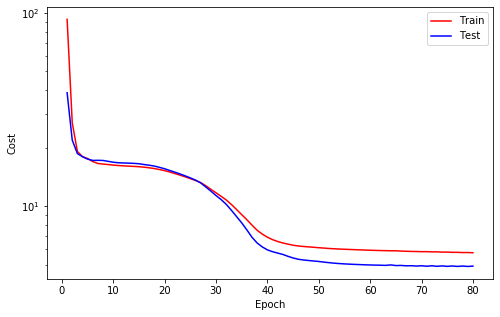

==> EarlyStop patience =  1 | Best test_cost: 4.8881




Epoch    81
Train_cost  = 5.7572 | Test_cost  = 4.8880 | 




Epoch    82
Train_cost  = 5.7412 | Test_cost  = 4.9074 | 
==> EarlyStop patience =  1 | Best test_cost: 4.8880




Epoch    83
Train_cost  = 5.7434 | Test_cost  = 4.8893 | 
==> EarlyStop patience =  2 | Best test_cost: 4.8880




Epoch    84
Train_cost  = 5.7276 | Test_cost  = 4.9078 | 
==> EarlyStop patience =  3 | Best test_cost: 4.8880




Epoch    85
Train_cost  = 5.7289 | Test_cost  = 4.8923 | 
==> EarlyStop patience =  4 | Best test_cost: 4.8880




Epoch    86
Train_cost  = 5.7136 | Test_cost  = 4.9091 | 
==> EarlyStop patience =  5 | Best test_cost: 4.8880
==> Execute Early Stopping at epoch: 86 | Best test_cost: 4.8880
==> Best model is saved at model/multivar


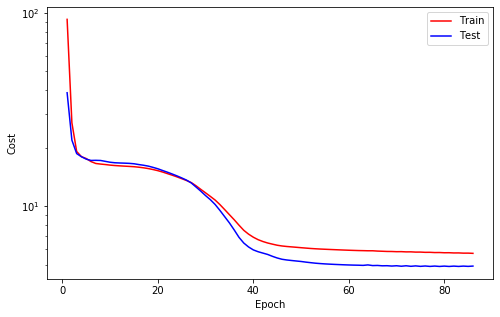

In [116]:
while True:
    train_cost = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
    
    # Logging
    callback.log(train_cost, test_cost)

    # Checkpoint
    callback.save_checkpoint()
        
    # Runtime Plotting
    callback.cost_runtime_plotting()
    
    # Early Stopping
    if callback.early_stopping(model, monitor="test_cost"):
        callback.plot_cost()
        break

## Sanity Check

In [117]:
from utils import data4pred, pred4pred

In [118]:
train_forecast_set = TimeSeriesDataset(ts_train, 'Temp', 1)
trainforecastloader = DataLoader(train_forecast_set)
test_forecast_set = TimeSeriesDataset(ts_test, 'Temp', 1)
testforecastloader = DataLoader(test_forecast_set)

(N, S, F): (2919, 1, 5)
Note: last 0 data excluded

(N, S, F): (729, 1, 5)
Note: last 0 data excluded



Text(0.5, 1.0, 'Test')

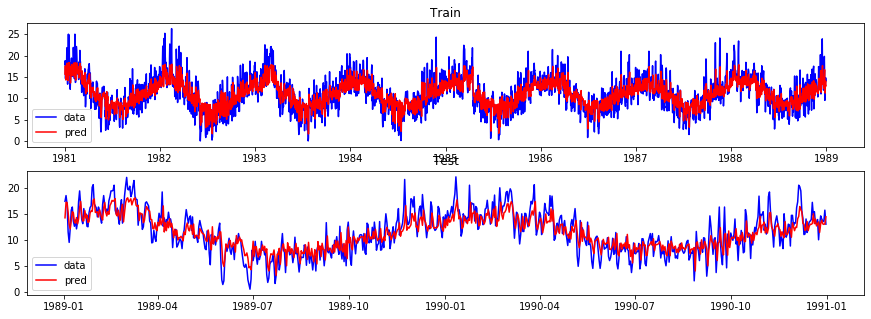

In [119]:
# Data For Pred
plt.figure(figsize=(15,5))

plt.subplot(211)
data4pred(model, train_forecast_set, trainforecastloader, device)
plt.title('Train')

plt.subplot(212)
data4pred(model, test_forecast_set, testforecastloader, device)
plt.title('Test')

Text(0.5, 1.0, 'Test')

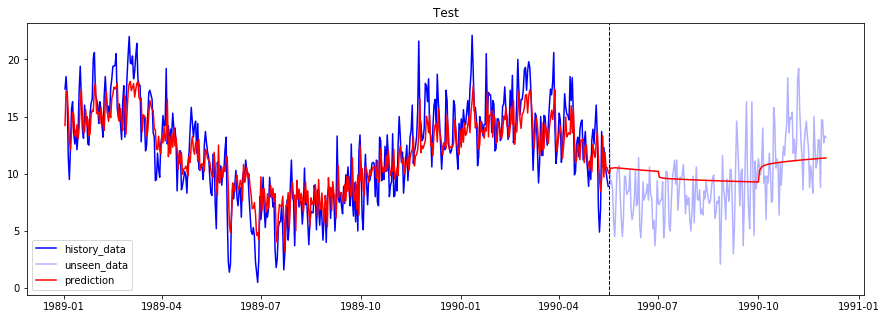

In [120]:
# Pred for pred
plt.figure(figsize=(15,5))
pred4pred(model, test_forecast_set, testforecastloader, device)
plt.title('Test')

#### Umumnya pred for pred hanya dapat memprediksi 2 hari kedepan. untuk hari selanjutnya tidak dipakai karena terjadi domino effect yang terjadi apabila disuatu hari tersebut terjadi kesalahan maka hari selanjutnya akan menjadi salah terus 